# Solve Morris Lecar Equations with Hardware

## Equations

$$ C\frac{dV}{dt} = \frac{I_{inj}}{A} - I_{leak} - I_{slow} - I_{fast} $$
$$ I_{leak} = g_{leak}(V - E_{leak}) $$
$$ I_{fast} = g_{fast}(V - E_{Na}) $$
$$ m_{\infty} = 0.5(1 + tanh(\frac{V - \beta_{m}}{\gamma{m}})) $$
$$ I_{slow} = g_{slow}w(V - E_{K}) $$
$$ w_{\infty} =  0.5(1 + tanh(\frac{V - \beta_{w}}{\gamma{w}})) $$
$$ \tau_{\infty} = \frac{1}{cosh(0.5\frac{V - \beta_{w}}{\gamma_{w}})} $$
$$ \frac{dw}{dt} = \phi\frac{w_{\infty} - w}{\tau_{\infty}} $$
$$ V = V + dt\frac{dV}{dt} $$
$$ w = w + dt\frac{dw}{dt} $$

## General Flow
1. Create the injected current timeseries with 25 mA noise around a 40 mA signal
2. Instantiate the bitstream as a block in Python
3. Create variables in DDR3 interface for V and W timeseries
4. Stimulate the logic block by iterating through V and W and sending and receiving the values for V and W
5. Run software simulation using the same injected current timeseries
6. Compare and display results from hardware and software solution

## Instatiate and download the overlay

In [1]:
from pynq import Overlay
ol = Overlay("./top.bit")

We can check the IPs in this overlay using the IP dictionary

In [2]:
ol.ip_dict

{'MorrisLecar_0': {'fullpath': 'MorrisLecar_0',
  'type': 'xilinx.com:hls:MorrisLecar:1.0',
  'bdtype': None,
  'state': None,
  'addr_range': 65536,
  'phys_addr': 1073741824,
  'mem_id': 's_axi_control',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_CONTROL_ADDR_WIDTH': '4',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'Component_Name': 'top_MorrisLecar_0_0',
   'clk_period': '10',
   'machine': '64',
   'combinational': '0',
   'latency': 'undef',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_CONTROL_BASEADDR': '0x40000000',
   'C_S_AXI_CONTROL_HIGHADDR': '0x4000FFFF'},
  'registers': {'CTRL': {'address_offset': 0,
    'size': 32,
    'access': 'read-write',
    'description': 'Control signals',
    'fields': {'AP_START': {'bit_offset': 0,
      'bit_width': 1,
      'description': 'Control signals',
      'access': 'read-write'},
     'AP_DONE': {'bit_offset': 1,
      'bit_width': 1,
      'description': 'Control signals',
      'acce

## Create aliases
Using the labels for the HLS IP and DMA listed above, we can create aliases which will make it easier to write and read the rest of the code in this example.

In [3]:
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
hls_ip = ol.MorrisLecar_0

## Check the status of the HLS IP

In [4]:
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

Note that the HLS IP has not started yet (AP_START=0). You can also see the IP is *idle* (AP_IDLE=1).

We will start the HLS IP and then start some transfers from the DMA.

We could initiate the DMA transfers first if we preferred. The DMA transfers would *stall* until the IP is started.

## Start the HLS IP

We can start the HLS IP by writing 0x81 to the control register. This will set the bit 0 (AP_START) to "1" and bit 7 (AUTO_RESTART) to "1". AUTO_RESTART means the IP will run continuously. If we don't set this then after the IP completes one fill operation or iteration, it will stop and wait untill AP_START is set again. We would have to set this every time we want the IP to process some data.

In [5]:
CONTROL_REGISTER = 0x0
hls_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

Check the correct bits have been set.

In [6]:
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=1, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

## DMA Send

Now we will send some data from DRAM to HLS IP.

Note the array used below is single (C float). This was selected to match the type of data width of the HLS IP and the widths used for the DMA. The DMA will transfer block of data and may "reformat" it based on the internal data widths in the hardware. The array we create in the notebook effects how the data is formatted in Python.

In [7]:
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

data_size = 1000
input_buffer = allocate(shape=(data_size,), dtype=np.float32)

Initialize the array.

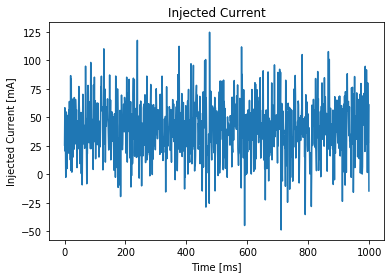

In [8]:
Iinj = 40 + 25*np.random.randn(data_size)

for i in range(data_size):
    input_buffer[i] = np.float32(Iinj[i]);

plt.plot(input_buffer)
plt.xlabel("Time [ms]")
plt.ylabel("Injected Current [mA]")
plt.title("Injected Current")
plt.show()

### Start the DMA transfer

In [9]:
import time
print(time.time())
start = time.time()
dma_send.transfer(input_buffer)

1648915448.984365


## DMA Receive

Readback data from the HLS IP and store in DRAM. Start by creating the output buffer.

In [10]:
output_buffer = allocate(shape=(data_size,), dtype=np.float32)
dma_recv.transfer(output_buffer)
end = time.time()
print(end)

1648915449.093591


### Plot the membrane potential

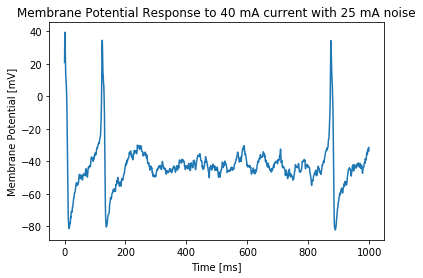

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import *

plt.plot(output_buffer)
plt.xlabel("Time [ms]")
plt.ylabel("Membrane Potential [mV]")
plt.title("Membrane Potential Response to 40 mA current with 25 mA noise")
plt.show()

In [12]:
print(end - start)

0.1079549789428711
